In [386]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import random
import zCurve as z
import math

In [387]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files

    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def compute_acceleration(pos_prev, pos_current, pos_next, dt):
    ax = (pos_next[0] - 2 * pos_current[0] + pos_prev[0]) / (dt ** 2)
    ay = (pos_next[1] - 2 * pos_current[1] + pos_prev[1]) / (dt ** 2)
    return ax, ay

def compute_relative_acceleration(pos_prev, pos_current, pos_next, dt):
    # Compute velocity vectors
    vx1 = (pos_current[0] - pos_prev[0]) / dt
    vy1 = (pos_current[1] - pos_prev[1]) / dt
    vx2 = (pos_next[0] - pos_current[0]) / dt
    vy2 = (pos_next[1] - pos_current[1]) / dt

    # Compute the change in velocity (acceleration vector)
    ax = (vx2 - vx1) / dt
    ay = (vy2 - vy1) / dt

    # Velocity direction (unit vector) at the middle position
    v_mag = math.hypot(vx1, vy1)
    if v_mag == 0:
        return 0.0, 0.0  # No motion

    # Tangential direction (unit vector)
    tx = vx1 / v_mag
    ty = vy1 / v_mag

    # Normal direction (perpendicular to tangential)
    nx = -ty
    ny = tx

    # Project acceleration onto tangential and normal directions
    a_tangential = ax * tx + ay * ty
    a_normal = ax * nx + ay * ny

    return a_normal, a_tangential

In [388]:
def generate_turning_data_3(num_points=100, left=True, initial_angle=math.pi/2, maxangle=math.pi/2, filename="trajectory.csv", initial_x=0, initial_y=0, initial_speed=5, changespeed=False):
    # Initialize variables
    position_x, position_y = initial_x, initial_y  # Start position
    previous_x, previous_y = initial_x, initial_y  # Start position
    
    turning_angle = initial_angle
    speed = initial_speed
    
    timestamp = 0
    delta_t = 4000  # Time step in microseconds
    padding = num_points//5

    # Open CSV file for writing
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["sampleTimeStamp.seconds", "sampleTimeStamp.microseconds", "x", "y", "speed",
                         "turning_angle", "accel_x", "accel_y"])

        for i in range(-2, num_points):
            if padding < i < num_points - padding:     
                turning_angle = initial_angle - (i-padding)/(num_points-2*padding) * maxangle * (-1 if left else 1)

            speed = initial_speed + (2 * i/num_points if changespeed else 0) #+ 0.01*math.sin(i/num_points*7*math.pi)
            previous_previous_x = previous_x
            previous_previous_y = previous_y
            previous_x = position_x
            previous_y = position_y
            position_x = position_x + math.cos(turning_angle) * speed * 16/delta_t
            position_y = position_y + math.sin(turning_angle) * speed * 16/delta_t
            
            acceleration_x, acceleration_y = compute_relative_acceleration((previous_previous_x, previous_previous_y), (previous_x, previous_y), (position_x, position_y), 50/delta_t)
            
            if i < 0:
                continue
            
            writer.writerow([int(timestamp / 1000000), timestamp % 1000000, position_x, position_y, speed, turning_angle, acceleration_x, acceleration_y])
            timestamp += delta_t
    
    return turning_angle, speed, position_x, position_y

In [389]:
length_tramo = 100
turning_angle = math.pi/2
speed = 5
end_x, end_y = 0, 0
nexamples = 5

left = False
keyword=("left" if left else "right")+"turn"

for id in range(nexamples):
    maxangle = (id+1)*math.pi/nexamples
    filename = "results/synthetic_turns_data/"+keyword+"_"+str(id)+".csv"
    generate_turning_data_3(num_points=length_tramo, left=left, initial_angle=turning_angle, maxangle=maxangle, filename=filename, initial_x=end_x, initial_y=end_y, initial_speed=speed, changespeed=False)

In [390]:
common_figsize = (6, 3)  # Common figure size for all plots
output_dir = "results/synthetic_turns_data/plots"  # Folder to save plots
os.makedirs(output_dir, exist_ok=True)

# ===============================
# Data File Processing
# ===============================
data_files = get_files_in_folder("results/synthetic_turns_data")
data_files.sort()

# ===============================
# DATA FILE PROCESSING
# ===============================
for file_path in data_files:
    if ".csv" not in file_path:
        continue
    
    print(file_path)

    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    data = pd.read_csv(file_path, sep=';')
    
    data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']
    
    if "synth" not in file_basename:
        continue

    # ===============================
    # Plot 1: Vehicle Position Colored by Speed
    # ===============================    
    plt.figure(figsize=common_figsize)
    plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20, vmin=5, vmax=7)
    plt.colorbar(label="Speed (m/s)")
    plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
    plt.xlabel("Longitude (position x)")
    plt.ylabel("Latitude (position y)")
    plt.title(f"Vehicle trajectory: {file_basename}")
    plt.axis('equal')
    plot1_filename = os.path.join(output_dir, f"{file_basename}_position.png")
    plt.savefig(plot1_filename, bbox_inches="tight")
    plt.show()
    plt.close()

results/synthetic_turns_data/rightturn_0.csv
results/synthetic_turns_data/rightturn_1.csv
results/synthetic_turns_data/rightturn_2.csv
results/synthetic_turns_data/rightturn_3.csv
results/synthetic_turns_data/rightturn_4.csv


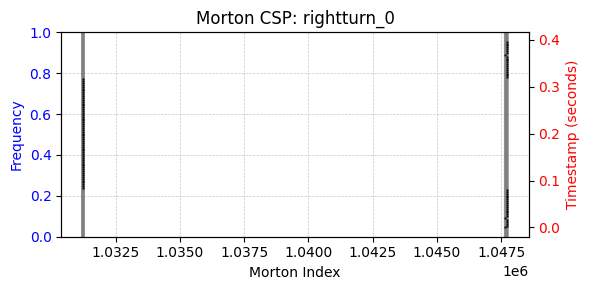

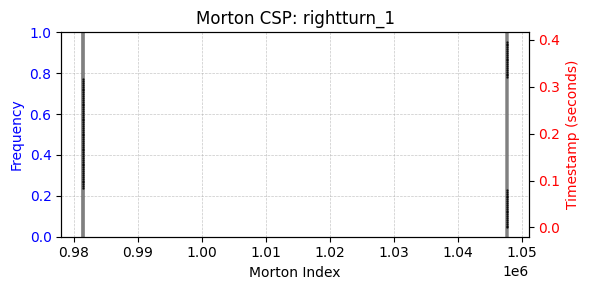

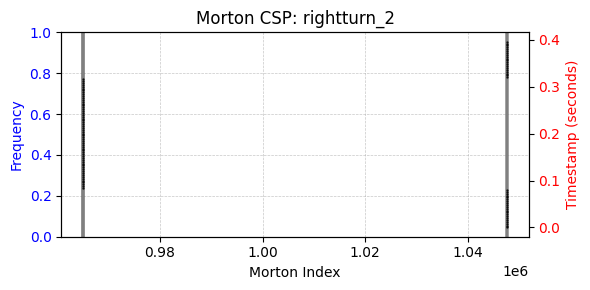

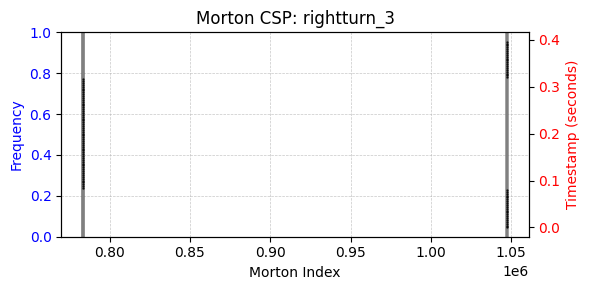

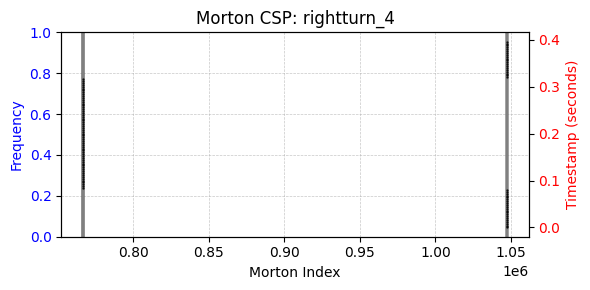

In [391]:
listofcsps = []

# ===============================
# DATA FILE PROCESSING
# ===============================
for file_path in data_files:
    if ".csv" not in file_path:
        continue
    
    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    data = pd.read_csv(file_path, sep=';')
    
    data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']

    accel_x = (data["accel_x"] + 10) * 100.0
    accel_y = (data["accel_y"] + 10) * 100.0

    # -------------------------------
    # Build Morton (Z-order) Index (if chosen or if building both)
    # -------------------------------
    data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=10) for x, y in zip(accel_x, accel_y)]
    listofcsps += [data['Morton_Index'].tolist()]
    
    fig, ax1 = plt.subplots(figsize=common_figsize)
    ax1.eventplot(data['Morton_Index'],
                  orientation='horizontal',
                  colors=["gray"],
                  alpha=0.5,
                  lineoffsets=0.5)
    ax1.set_xlabel("Morton Index")
    ax1.set_ylabel('Frequency', color='b')
    ax1.set_ylim((0, 1))
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.scatter(data['Morton_Index'],
                data['timestamp']/1000000.0,
                color='black',
                s=0.5,
                alpha=0.8,
                label="Timestamps")
    ax2.set_ylabel("Timestamp (seconds)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    #ax1.set_xlim(0, 3500000) #set once the CSPs are analysed!

    plt.title(f"Morton CSP: {file_basename}")
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plot_morton_filename = os.path.join(output_dir, f"{file_basename}_morton.png")
    plt.savefig(plot_morton_filename, bbox_inches="tight")
    plt.show()
    plt.close()

In [392]:
nbins = 30 # more bins = thinner bars
barthreshold = 5 # higher threshold = fewer bars

allmortonindices = []
for csp in listofcsps:
    allmortonindices += csp
mortonindexmin = min(allmortonindices)
mortonindexmax = max(allmortonindices)
totalrange = mortonindexmax - mortonindexmin
margins = totalrange/50.0
numsignals = len(listofcsps)

bincounter = [0]*nbins
for m in allmortonindices:
    assigned = False
    for bin in range(nbins):
        binmin = mortonindexmin + totalrange/nbins*bin
        binmax = binmin + totalrange/nbins
        if binmin <= m < binmax:
            bincounter[bin] += 1
            assigned = True
    if not assigned:
        bincounter[-1] += 1

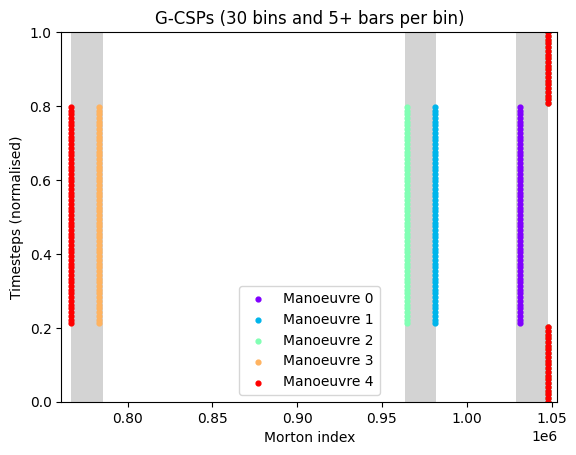

In [393]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(1/(len(listofcsps)-1)*i) for i in range(len(listofcsps))]
decforyaxis = StrMethodFormatter('{x:,.1f}')

plt.figure()
plt.bar([totalrange/nbins/2+mortonindexmin+totalrange/(nbins)*x for x in range(nbins)], [1 if b > barthreshold else 0 for b in bincounter], width=totalrange/nbins, color="lightgray")
for i, csp in enumerate(listofcsps):
    ranges = [x / (len(csp) - 1) for x in range(len(csp))]
    plt.scatter(csp, ranges, color=colors[i], s=12, label="Manoeuvre "+str(i))
plt.ylabel("Timesteps (normalised)")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
plt.title("G-CSPs ("+str(nbins)+" bins and " + str(barthreshold)+"+ bars per bin)")

#plt.xlim(650000, 1100000) #set once the CSPs are analysed!
plt.legend(loc='best')

plt.savefig("results/synthetic_turns_data/plots/"+keyword+"_gcsp_"+str(nbins)+"bins.png")
plt.show()
plt.close()